In [56]:
import numpy as np
import string
import sys
import matplotlib.pyplot as plt


import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import WordPunctTokenizer
from nltk.tokenize import sent_tokenize, word_tokenize, wordpunct_tokenize
from nltk.tokenize import RegexpTokenizer

import pandas as pd

from gensim.models import Word2Vec, KeyedVectors

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb

[nltk_data] Downloading package punkt to /home/franzio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/franzio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/franzio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### 1. Load data

In [2]:
train_path = './train/train.csv'
test_path = './test/test.csv'
sample_submission_path = './sample_submission/sample_submission.csv'

train_data = pd.read_csv(train_path, encoding='utf-8')
test_data = pd.read_csv(test_path, encoding='utf-8')
sample_submission = pd.read_csv(sample_submission_path, encoding='utf-8')

In [3]:
# extract text/sentences from data frame
train_text = train_data.text
test_text = test_data.text

# build list with all train and test sentences
n_train = train_data.text.shape[0]
n_test = test_data.text.shape[0]

all_text = train_text.append(test_text, ignore_index=True)

In [4]:
# extract train target from data
target = np.array(train_data.author)
target.shape

(19579,)

#### 2. Data cleaning

First of all it is necessary to clean the data. For that purpose the sentences are separated into single words. Then stopwords and punctuation are deletd and the single words are reduced to their word stem.

In [5]:
def text_cleaning(sen):
    tokenizer = RegexpTokenizer(r'\w+')
    tok = tokenizer.tokenize(sen)
    
    lemm = WordNetLemmatizer()
    stem = [lemm.lemmatize(t) for t in tok]
    
    stop_words = set(stopwords.words('english'))
    return list(filter(lambda ts: ts.lower() not in stop_words, stem))

In [6]:
clean_sents = [text_cleaning(at) for at in all_text]

In [19]:
clean_sents[0]

['process',
 'however',
 'afforded',
 'mean',
 'ascertaining',
 'dimension',
 'dungeon',
 'might',
 'make',
 'circuit',
 'return',
 'point',
 'whence',
 'set',
 'without',
 'aware',
 'fact',
 'perfectly',
 'uniform',
 'seemed',
 'wall']

In [7]:
joined_sents = [' '.join(cs) for cs in clean_sents]

In [20]:
joined_sents[0]

'process however afforded mean ascertaining dimension dungeon might make circuit return point whence set without aware fact perfectly uniform seemed wall'

#### 3. Word embedding

The single words are now embedded within a high-dimensional space, such that every word is represented by one vector. Here, the TfidVectorizer is used which is equivalent to a combination of first applying CountVectorizer followed by TfidfTransformer. The former transforms the text document into a matrix of counts (bag of words). The latter transforms the count matrix into one accounting for the frequency of words.

In [26]:
tfid_vect = TfidfVectorizer()
text_vect = tfid_vect.fit_transform(joined_sents)

In [27]:
# split the vector again into training and test data
train_new = text_vect[:n_train]
test_new = text_vect[n_train:]

#train_new = train_new.toarray()
#test_new = test_new.toarray()

#### 4. Dimensionality reduction

For the purpose of visualising the data, the high dimensional vectors are reduced to two-dimensional ones.

In [28]:
pca = PCA(n_components=2)
result = pca.fit_transform(train_new.toarray())

In [29]:
ix_eap = np.where(target == 'EAP')
ix_hpl = np.where(target == 'HPL')
ix_mws = np.where(target == 'MWS')

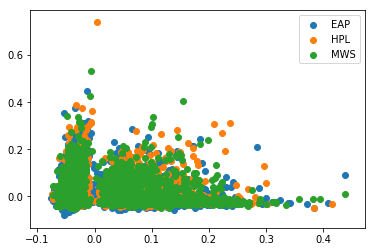

In [30]:
plt.scatter(result[ix_eap, 0], result[ix_eap, 1], label = 'EAP')
plt.scatter(result[ix_hpl, 0], result[ix_hpl, 1], label = 'HPL')
plt.scatter(result[ix_mws, 0], result[ix_mws, 1], label = 'MWS')
plt.legend()
plt.show()

#### 5. Training of the model

Different classification models are used in order to find out which works best.

In [31]:
# split data into training and validation set
X_train, X_val, y_train, y_val = train_test_split(train_new, target, test_size=0.2, random_state=1)

##### 5.1 Logistic regression

In [34]:
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
text_clf = clf.fit(X_train, y_train)

predicted = text_clf.predict(X_val)
print(np.mean(predicted == y_val))

predicted = text_clf.predict_proba(X_val)
print(log_loss(y_val, predicted))

0.805669050051
0.498793588463


##### 5.2 Gradient Boosting

In [53]:
clf_gb = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1)

text_clf_gb = clf_gb.fit(X_train, y_train)

predicted = text_clf_gb.predict(X_val)
print(np.mean(predicted == y_val))

predicted = text_clf_gb.predict_proba(X_val)
print(log_loss(y_val, predicted))

0.669816138917
0.785216082253


##### 5.3 XGBoost

In [68]:
gbm = xgb.XGBClassifier(max_depth=5, n_estimators=300, learning_rate=0.5)

text_clf_gbm = gbm.fit(X_train, y_train)

predicted = text_clf_gbm.predict(X_val)
print(np.mean(predicted == y_val))

predicted = text_clf_gbm.predict_proba(X_val)
print(log_loss(y_val, predicted))

0.740551583248
0.620294797499
